# Shapash in Jupyter - Overview

<b>With this tutorial you:</b><br />
Understand how Shapash works in Jupyter Notebook
with a simple use case<br />

Contents:
- Build a Regressor
- Compile Shapash SmartExplainer
- Display global and local explanability
- Export local summarized explainability with to_pandas method
- Save Shapash object in pickle file

Data from Kaggle [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
from category_encoders import OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

## Building Supervized Model 

In [2]:
from shapash.data.data_loader import data_loading
house_df, house_dict = data_loading('house_prices')

In [3]:
y_df=house_df['SalePrice'].to_frame()
X_df=house_df[house_df.columns.difference(['SalePrice'])]

In [4]:
house_df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,2-Story 1946 & Newer,Residential Low Density,8450,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,2,2008,Warranty Deed - Conventional,Normal Sale,208500
2,1-Story 1946 & Newer All Styles,Residential Low Density,9600,Paved,Regular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Veenker,...,0,0,0,0,0,5,2007,Warranty Deed - Conventional,Normal Sale,181500
3,2-Story 1946 & Newer,Residential Low Density,11250,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Inside lot,Gentle slope,College Creek,...,0,0,0,0,0,9,2008,Warranty Deed - Conventional,Normal Sale,223500
4,2-Story 1945 & Older,Residential Low Density,9550,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Corner lot,Gentle slope,Crawford,...,272,0,0,0,0,2,2006,Warranty Deed - Conventional,Abnormal Sale,140000
5,2-Story 1946 & Newer,Residential Low Density,14260,Paved,Slightly irregular,Near Flat/Level,"All public Utilities (E,G,W,& S)",Frontage on 2 sides of property,Gentle slope,Northridge,...,0,0,0,0,0,12,2008,Warranty Deed - Conventional,Normal Sale,250000


#### Encoding Categorical Features 

In [5]:
from category_encoders import OrdinalEncoder

categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

#### Train / Test Split

In [6]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

#### Model Fitting

In [7]:
regressor = LGBMRegressor(n_estimators=200).fit(Xtrain,ytrain)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2986
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 66
[LightGBM] [Info] Start training from score 182319.757078


In [8]:
y_pred = pd.DataFrame(regressor.predict(Xtest),columns=['pred'],index=Xtest.index)

## Understand my model with shapash

#### Declare and Compile SmartExplainer 

In [9]:
from shapash import SmartExplainer

In [10]:
xpl = SmartExplainer(
    model=regressor,
    preprocessing=encoder, # Optional: compile step can use inverse_transform method
    features_dict=house_dict  # Optional parameter, dict specifies label for features name 
)

In [11]:
xpl.compile(x=Xtest,
 y_pred=y_pred,
 y_target=ytest, # Optional: allows to display True Values vs Predicted Values
 )

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x7f259c8e77c0>


#### Display features importance

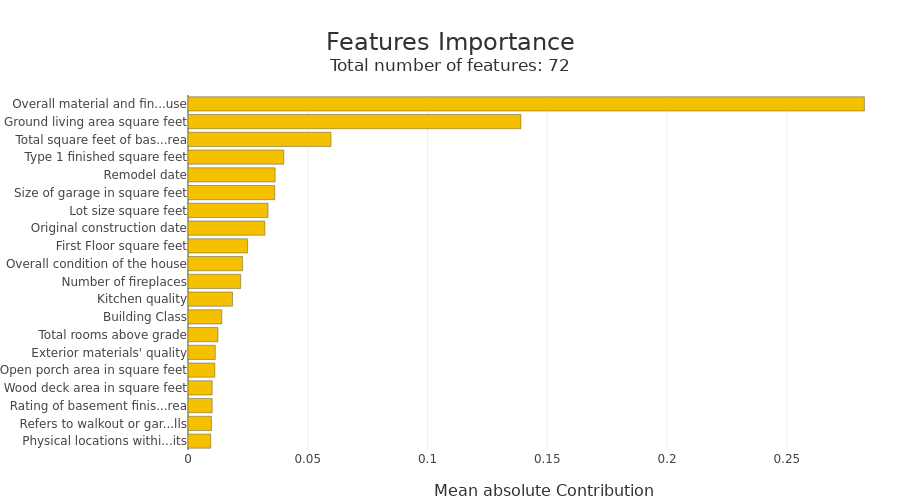

In [12]:
xpl.plot.features_importance()

#### Focus on a specific subset

You can use the features_importance method to compare the contribution of features of a subset to the global features importance

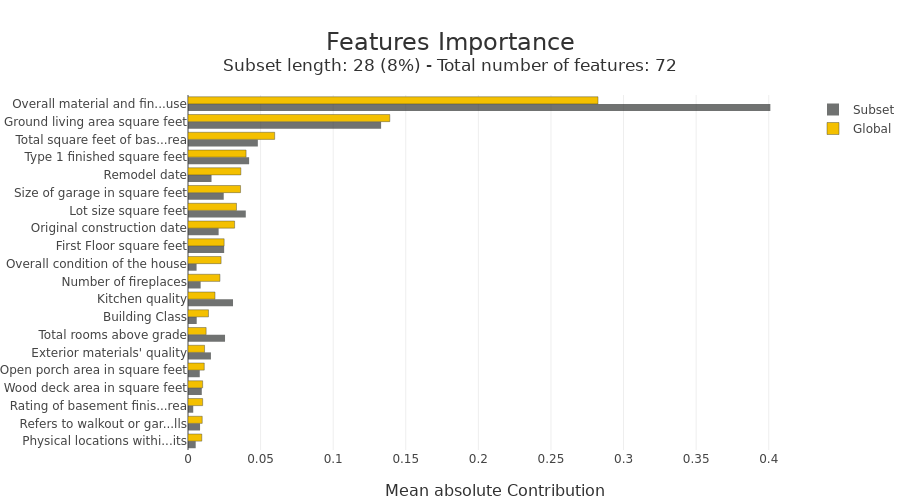

In [13]:
subset = [ 168, 54, 995, 799, 310, 322, 1374,
          1106, 232, 645, 1170, 1229, 703, 66,  
          886, 160, 191, 1183, 1037, 991, 482,  
          725, 410, 59, 28, 719, 337, 36]
xpl.plot.features_importance(selection=subset)

#### Understand how a feature contributes

- The contribution_plot allows to analyse how one feature affects prediction
- Type of plot depends on the type of features
- You can use feature name, feature label or feature number to specify which feature you want to analyze

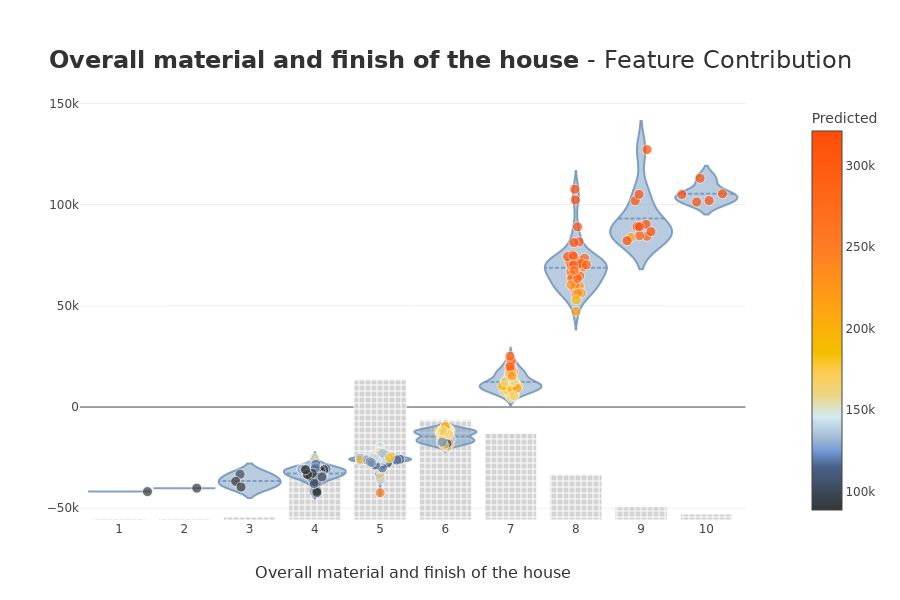

In [14]:
xpl.plot.contribution_plot("OverallQual")

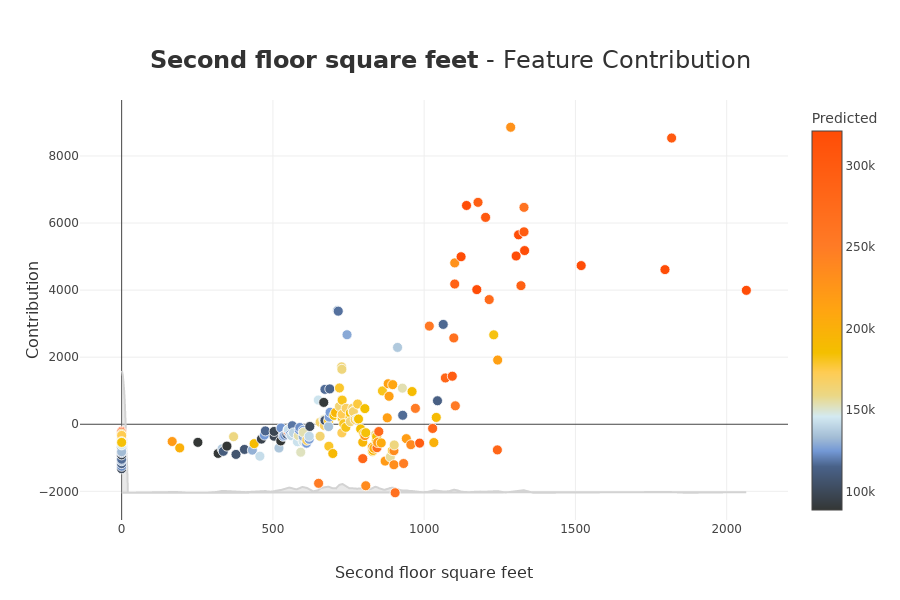

In [15]:
xpl.plot.contribution_plot("Second floor square feet")

## Display a Summarized but Explicit local explainability

#### Filter method

Use the filter method to specify how to summarize local explainability <br />
There are 4 parameters to customize the summary: <br />
- max_contrib : maximum number of criteria to display
- threshold : minimum value of the contribution (in absolute value) necessary to display a criterion
- positive : display only positive contribution? Negative?(default None)
- features_to_hide : list of features you don't want to display

In [16]:
xpl.filter(max_contrib=8,threshold=100)

#### Display local plot, applying your filter

you can use row_num, index or query parameter to specify which prediction you want to explain

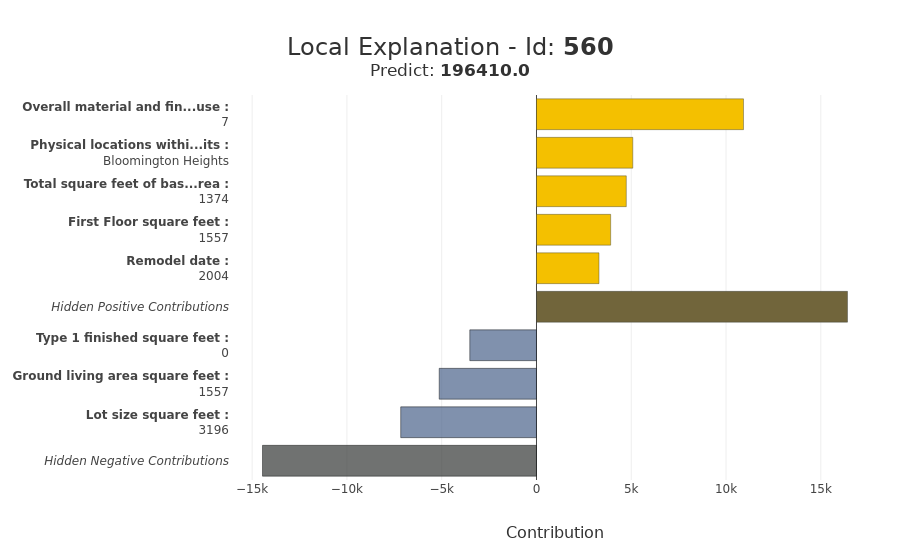

In [17]:
xpl.plot.local_plot(index=560)

## Save your Explainer & Export results

#### Export your local explanation to pandas DataFrame:

to_pandas method has the same parameters as the filter method

In [18]:
summary_df= xpl.to_pandas(
    max_contrib=3, # Number Max of features to show in summary
    threshold=5000,
)

In [19]:
summary_df.head()

,pred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
259,211538.742157,Ground living area square feet,1792,13995.651927,Overall material and finish of the house,7,13539.441353,Total square feet of basement area,963,-5652.206854
268,178786.677257,Ground living area square feet,2192,27967.966278,Overall material and finish of the house,5,-26133.987559,Overall condition of the house,8,7799.924798
289,111985.324660,Overall material and finish of the house,5,-25571.348315,Ground living area square feet,900,-16006.763921,Total square feet of basement area,882,-5456.989325
650,73456.522515,Overall material and finish of the house,4,-34517.073676,Ground living area square feet,630,-21350.707866,Total square feet of basement area,630,-12699.371236
1234,136249.557316,Overall material and finish of the house,5,-26469.235405,Ground living area square feet,1188,-10980.550285,Condition of sale,Abnormal Sale,-5240.009373


#### Save your explainer in Pickle File

You can save the SmartExplainer Object in a pickle file to make new plots later or launch the WebApp again

In [20]:
xpl.save('./xpl.pkl')